In [1]:
# Import necessary libraries and modules for project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
covid_df = pd.read_csv('./Data/Covid Data.csv')

In [3]:
# Ensure dataset is loaded properly
covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


Important features to note of the dataset: 21 unique features, 1,048,576 unique patients
- For Boolean features, 1 denotes yes and 2 denotes no - unique features may also utilize 1 and 2 to denote different meanings
- 97 and 99 denote missing data
- Sex: 1 denotes female and 2 denotes male
- Classification: 1-3 denote patient diagnosed with covid (to varying degrees of severity) Values $\geq$ 4 denote patient not a carrier or test was inconclusive
- Patient type: 1 denotes patient returned home and 2 denotes patient is hospitalized
- Date Died: Valid date denotes a patient that has passed away while a date of 9999-99-99 denotes a patient that is still alive

In [4]:
# Initial overview and exploration of COVID Dataset

# Print the dimensions (number of rows and columns) of the original dataset
print('Dimensions of COVID Dataset:', covid_df.shape)

# Print the names of the attributes (columns) in the original dataset
print('Attributes of COVID Dataset:', covid_df.columns.values)

# Iterate through each column in the DataFrame
for column in covid_df.columns:
    # Print the value counts for each unique value in the column
    # This will give you a frequency distribution of the values
    print(f"Value counts for column '{column}':")
    print(covid_df[column].value_counts())
    print()  # Newline for better readability

Dimensions of COVID Dataset: (1048575, 21)
Attributes of COVID Dataset: ['USMER' 'MEDICAL_UNIT' 'SEX' 'PATIENT_TYPE' 'DATE_DIED' 'INTUBED'
 'PNEUMONIA' 'AGE' 'PREGNANT' 'DIABETES' 'COPD' 'ASTHMA' 'INMSUPR'
 'HIPERTENSION' 'OTHER_DISEASE' 'CARDIOVASCULAR' 'OBESITY' 'RENAL_CHRONIC'
 'TOBACCO' 'CLASIFFICATION_FINAL' 'ICU']
Value counts for column 'USMER':
USMER
2    662903
1    385672
Name: count, dtype: int64

Value counts for column 'MEDICAL_UNIT':
MEDICAL_UNIT
12    602995
4     314405
6      40584
9      38116
3      19175
8      10399
10      7873
5       7244
11      5577
13       996
7        891
2        169
1        151
Name: count, dtype: int64

Value counts for column 'SEX':
SEX
1    525064
2    523511
Name: count, dtype: int64

Value counts for column 'PATIENT_TYPE':
PATIENT_TYPE
1    848544
2    200031
Name: count, dtype: int64

Value counts for column 'DATE_DIED':
DATE_DIED
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       9

From our initial walkthrough of the data, there are a couple of attributes we need to clean-up:
- For records where 'SEX' = 2, they have 'PREGNANT' = 97 or 98; we should go and change the value for these records so 'PREGNANT' = 2 to reflect not pregnant and be consistent with the values found for records where patient is female
    - Additionally, we may have records where 'SEX' = 1 and have 'PREGNANT' = 97 or 98, in this case we should change these to have NaN as a new value to later apply an imputation method over to account for the missing values for these attributes 
- For records where 'PATIENT_TYPE' = 1, they have 'ICU' and 'INTUBED' = 97 or 99; we should go and change the value for these records so 'ICU' and 'INTUBED' = 2 to reflect not having been admitted to the ICU or being connected to a ventilator as if patient went home, it is safe to assume they cannot have been admmited to the ICU or placed on a ventilator
- For records where related to different medical condition (pneumonia, asthma, etc.) = 97, 98, or 99; we should change these to have NaN as a new value to later apply an imputation method over to account for the missing values for these attributes
- For all records, we should generate a new attribute 'ALIVE' that will be considered a Boolean feature; records with valid date will have an associated value in 'ALIVE' being 1 to denote they have passed and records with invalid date will have an associated value in 'ALIVE' being 2 to denote they are alive
- Need to be careful while cleaning data, as while 97, 98, and 99 have the context as being missing data, for 'AGE', these values can represent valid ages

In [5]:
# Generate a report of the current missing values in the dataset

# Initialize a dictionary to store counts of 97, 98, and 99 for each column
report = {}

# List of values to check
missing_values = [97, 98, 99]

# Iterate through each column in the DataFrame
for column in covid_df.columns:
    # Initialize counts for the current column
    counts = {value: covid_df[column].isin([value]).sum() for value in missing_values}
    
    # Store the counts in the report dictionary
    report[column] = counts

# Convert the report dictionary to a DataFrame for better readability
report_df = pd.DataFrame(report).T
report_df.columns = [f'Count_{value}' for value in missing_values]

# Print the report DataFrame
print(report_df)

                      Count_97  Count_98  Count_99
USMER                        0         0         0
MEDICAL_UNIT                 0         0         0
SEX                          0         0         0
PATIENT_TYPE                 0         0         0
DATE_DIED                    0         0         0
INTUBED                 848544         0      7325
PNEUMONIA                    0         0     16003
AGE                        135       124        86
PREGNANT                523511      3754         0
DIABETES                     0      3338         0
COPD                         0      3003         0
ASTHMA                       0      2979         0
INMSUPR                      0      3404         0
HIPERTENSION                 0      3104         0
OTHER_DISEASE                0      5045         0
CARDIOVASCULAR               0      3076         0
OBESITY                      0      3032         0
RENAL_CHRONIC                0      3006         0
TOBACCO                      0 

In [6]:
# Data Processing

# Create a copy of the original DataFrame to work on, preserving the original data
cleaned_df = covid_df.copy()

# Update 'PREGNANT' column:
# - For female patients ('SEX' == 2) with 'PREGNANT' values 97 or 98, set 'PREGNANT' to 2 (not pregnant).
# - For male patients ('SEX' == 1) with 'PREGNANT' values 97 or 98, set 'PREGNANT' to NaN (not applicable).
cleaned_df.loc[(cleaned_df['SEX'] == 2) & (cleaned_df['PREGNANT'].isin([97, 98])), 'PREGNANT'] = 2
cleaned_df.loc[(cleaned_df['SEX'] == 1) & (cleaned_df['PREGNANT'].isin([97, 98])), 'PREGNANT'] = np.nan

# Update 'ICU' and 'INTUBED' columns for patients of type 1:
# - For ICU: If 'PATIENT_TYPE' is 1 and 'ICU' has values 97 or 99, set 'ICU' to 2 (not in ICU).
# - For INTUBED: If 'PATIENT_TYPE' is 1 and 'INTUBED' has values 97 or 99, set 'INTUBED' to 2 (not intubated).
cleaned_df.loc[(cleaned_df['PATIENT_TYPE'] == 1) & (cleaned_df['ICU'].isin([97, 99])), 'ICU'] = 2
cleaned_df.loc[(cleaned_df['PATIENT_TYPE'] == 1) & (cleaned_df['INTUBED'].isin([97, 99])), 'INTUBED'] = 2

# Define a list of medical conditions to process
medical_conditions = ['PNEUMONIA', 'ASTHMA', 'COPD', 'DIABETES', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']

# Iterate through each medical condition column:
# - For each column, set values 97, 98, and 99 to NaN (indicating missing or not applicable values)
for condition in medical_conditions:
    cleaned_df.loc[cleaned_df[condition].isin([97, 98, 99]), condition] = np.nan

# Convert 'DATE_DIED' to datetime format:
# - Use 'errors=coerce' to convert invalid parsing to NaT (Not a Time).
cleaned_df['DATE_DIED'] = pd.to_datetime(cleaned_df['DATE_DIED'], errors='coerce')

# Create 'ALIVE' column:
# - If 'DATE_DIED' is not NaT, set 'ALIVE' to 1 (alive).
# - If 'DATE_DIED' is NaT, set 'ALIVE' to 2 (deceased or missing date).
cleaned_df['ALIVE'] = np.where(cleaned_df['DATE_DIED'].notna(), 1, 2)

# Drop 'DATE_DIED' column from the DataFrame as it is no longer needed after creating 'ALIVE'
cleaned_df.drop(columns=['DATE_DIED'], inplace=True)


In [7]:
# Generate a report of the current missing values in the dataset after initial cleaning

# Initialize a dictionary to store counts of 97, 98, and 99 for each column
report_cleaned = {}

# Iterate through each column in the DataFrame
for column in cleaned_df.columns:
    # Initialize counts for the current column
    counts = {value: cleaned_df[column].isin([value]).sum() for value in missing_values}
    
    # Store the counts in the report dictionary
    report_cleaned[column] = counts

# Convert the report dictionary to a DataFrame for better readability
report_cleaned_df = pd.DataFrame(report_cleaned).T
report_cleaned_df.columns = [f'Count_{value}' for value in missing_values]

# Print the report DataFrame
print(report_cleaned_df)

                      Count_97  Count_98  Count_99
USMER                        0         0         0
MEDICAL_UNIT                 0         0         0
SEX                          0         0         0
PATIENT_TYPE                 0         0         0
INTUBED                      0         0      7325
PNEUMONIA                    0         0         0
AGE                        135       124        86
PREGNANT                     0         0         0
DIABETES                     0         0         0
COPD                         0         0         0
ASTHMA                       0         0         0
INMSUPR                      0      3404         0
HIPERTENSION                 0         0         0
OTHER_DISEASE                0         0         0
CARDIOVASCULAR               0         0         0
OBESITY                      0         0         0
RENAL_CHRONIC                0         0         0
TOBACCO                      0         0         0
CLASIFFICATION_FINAL         0 

In [8]:
# Reapply cleaning to account for missing values still permuating the dataset

# Iterate through each column in the cleaned DataFrame
for column in cleaned_df.columns:
    # Skip 'AGE' column as values 97, 98, and 99 are valid in this context
    # Check if the column's data type is integer or float
    if column != 'AGE' and cleaned_df[column].dtype in [np.int64, np.float64]:
        # Replace occurrences of the values_to_replace with NaN in the specified column
        cleaned_df.loc[cleaned_df[column].isin(missing_values), column] = np.nan


In [9]:
# Generate a report of the current missing values in the dataset after second cleaning

# Initialize a dictionary to store counts of 97, 98, and 99 for each column
report_cleaned = {}

# Iterate through each column in the DataFrame
for column in cleaned_df.columns:
    # Initialize counts for the current column
    counts = {value: cleaned_df[column].isin([value]).sum() for value in missing_values}
    
    # Store the counts in the report dictionary
    report_cleaned[column] = counts

# Convert the report dictionary to a DataFrame for better readability
report_cleaned_df = pd.DataFrame(report_cleaned).T
report_cleaned_df.columns = [f'Count_{value}' for value in missing_values]

# Print the report DataFrame
print(report_cleaned_df)

                      Count_97  Count_98  Count_99
USMER                        0         0         0
MEDICAL_UNIT                 0         0         0
SEX                          0         0         0
PATIENT_TYPE                 0         0         0
INTUBED                      0         0         0
PNEUMONIA                    0         0         0
AGE                        135       124        86
PREGNANT                     0         0         0
DIABETES                     0         0         0
COPD                         0         0         0
ASTHMA                       0         0         0
INMSUPR                      0         0         0
HIPERTENSION                 0         0         0
OTHER_DISEASE                0         0         0
CARDIOVASCULAR               0         0         0
OBESITY                      0         0         0
RENAL_CHRONIC                0         0         0
TOBACCO                      0         0         0
CLASIFFICATION_FINAL         0 

In [10]:
# initial overview and exploration of cleaned COVID Dataset

# Print the dimensions (number of rows and columns) of the cleaned dataset
print('Dimensions of COVID Dataset:', cleaned_df.shape)

# Print the names of the attributes (columns) in the cleaned dataset
print('Attributes of COVID Dataset:', cleaned_df.columns.values)

# Iterate through each column in the DataFrame
for column in cleaned_df.columns:
    # Print the value counts for each unique value in the column
    # This will give you a frequency distribution of the values
    print(f"Value counts for column '{column}':")
    print(cleaned_df[column].value_counts())
    print()  # Newline for better readability

Dimensions of COVID Dataset: (1048575, 21)
Attributes of COVID Dataset: ['USMER' 'MEDICAL_UNIT' 'SEX' 'PATIENT_TYPE' 'INTUBED' 'PNEUMONIA' 'AGE'
 'PREGNANT' 'DIABETES' 'COPD' 'ASTHMA' 'INMSUPR' 'HIPERTENSION'
 'OTHER_DISEASE' 'CARDIOVASCULAR' 'OBESITY' 'RENAL_CHRONIC' 'TOBACCO'
 'CLASIFFICATION_FINAL' 'ICU' 'ALIVE']
Value counts for column 'USMER':
USMER
2.0    662903
1.0    385672
Name: count, dtype: int64

Value counts for column 'MEDICAL_UNIT':
MEDICAL_UNIT
12.0    602995
4.0     314405
6.0      40584
9.0      38116
3.0      19175
8.0      10399
10.0      7873
5.0       7244
11.0      5577
13.0       996
7.0        891
2.0        169
1.0        151
Name: count, dtype: int64

Value counts for column 'SEX':
SEX
1.0    525064
2.0    523511
Name: count, dtype: int64

Value counts for column 'PATIENT_TYPE':
PATIENT_TYPE
1.0    848544
2.0    200031
Name: count, dtype: int64

Value counts for column 'INTUBED':
INTUBED
2.0    1007594
1.0      33656
Name: count, dtype: int64

Value counts fo

Now that we done our initial processing to clean up the original dataset, I can run a quick report to see the current count of NaN values in our attributes

In [11]:
# Report of counts of NaN values for each column in cleaned_df_2
nan_report = cleaned_df.isna().sum()

# Convert the NaN report to a DataFrame for better readability
nan_report_df = pd.DataFrame(nan_report, columns=['NaN_Count'])

# Print the NaN report DataFrame
print(nan_report_df)

# Calculate total NaN counts across all columns
total_nan_count = nan_report.sum()

# Print the total NaN count
print("\nTotal NaN counts in the DataFrame:", total_nan_count)

# Count the number of rows with at least one NaN value
rows_with_missing_values = cleaned_df.isna().any(axis=1).sum()

# Print the result
print("Number of patient records with at least one missing value:", rows_with_missing_values)


                      NaN_Count
USMER                         0
MEDICAL_UNIT                  0
SEX                           0
PATIENT_TYPE                  0
INTUBED                    7325
PNEUMONIA                 16003
AGE                           0
PREGNANT                   3754
DIABETES                   3338
COPD                       3003
ASTHMA                     2979
INMSUPR                    3404
HIPERTENSION               3104
OTHER_DISEASE              5045
CARDIOVASCULAR             3076
OBESITY                    3032
RENAL_CHRONIC              3006
TOBACCO                    3220
CLASIFFICATION_FINAL          0
ICU                        7488
ALIVE                         0

Total NaN counts in the DataFrame: 67777
Number of patient records with at least one missing value: 28909


With this initial understanding of how many NaN values I have, I can make considerations towards how to handle these NaN values:
- Given that this dataset has 1,048,576 unique patients and only 28,909 unique patients have NaN values, it would be very miniscule to just out right drop those patient records for the purpose of modeling and performing data analysis
- If I decided to perform imputation, I would consider imputing missing values with the mode of those columns given the nature of the attributes that have NaN values; most of the attributes are Boolean features, and if we consider the missing values to be misisng at random, imputing the values with the mode of these attributes can help preserve the overall distribution of values in the attribute

To account for these NaN values, I am considering to just drop the values as dropping 28,909 unique patients would be only losing roughly 2.76% of the overall data from our original 1,048,576 unique patients. However, I will still include a simple code block to show the process of imputation with the mode for our NaN values.

In [12]:
# Copy the DataFrame to avoid modifying the original
imputed_df = cleaned_df.copy()

# List of binary attributes
binary_attributes = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD','ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']

# Impute missing values for binary attributes with the mode (most frequent value)
for column in binary_attributes:
    # Get the most frequent value
    mode_value = imputed_df[column].mode()[0]
    imputed_df[column].fillna(mode_value, inplace=True)


C:\Users\antho\AppData\Local\Temp\ipykernel_19776\3506212503.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_df[column].fillna(mode_value, inplace=True)


In [13]:
# Generate the NaN count report after imputation
nan_count_after_imputation = imputed_df.isna().sum()

# Create a DataFrame to make the report more readable
imputed_nan_report_df = pd.DataFrame(nan_count_after_imputation, columns=['NaN_Count'])

# Print the report
print(imputed_nan_report_df)

                      NaN_Count
USMER                         0
MEDICAL_UNIT                  0
SEX                           0
PATIENT_TYPE                  0
INTUBED                       0
PNEUMONIA                     0
AGE                           0
PREGNANT                      0
DIABETES                      0
COPD                          0
ASTHMA                        0
INMSUPR                       0
HIPERTENSION                  0
OTHER_DISEASE                 0
CARDIOVASCULAR                0
OBESITY                       0
RENAL_CHRONIC                 0
TOBACCO                       0
CLASIFFICATION_FINAL          0
ICU                           0
ALIVE                         0


In [14]:
# Drop records with any NaN values from cleaned_df
dropped_df = cleaned_df.dropna()

# Print the shape of the new DataFrame to confirm the number of records
print('Dimensions of dropped_df:', dropped_df.shape)

# Generate the NaN count report after imputation
nan_count_after_drop = dropped_df.isna().sum()

# Create a DataFrame to make the report more readable
dropped_nan_report_df = pd.DataFrame(nan_count_after_drop, columns=['NaN_Count'])

# Print the report
print(dropped_nan_report_df)


Dimensions of dropped_df: (1019666, 21)
                      NaN_Count
USMER                         0
MEDICAL_UNIT                  0
SEX                           0
PATIENT_TYPE                  0
INTUBED                       0
PNEUMONIA                     0
AGE                           0
PREGNANT                      0
DIABETES                      0
COPD                          0
ASTHMA                        0
INMSUPR                       0
HIPERTENSION                  0
OTHER_DISEASE                 0
CARDIOVASCULAR                0
OBESITY                       0
RENAL_CHRONIC                 0
TOBACCO                       0
CLASIFFICATION_FINAL          0
ICU                           0
ALIVE                         0


Now that the NaN values have been taken care of, I can begin the process of building out a model. Before that, we need to consider what questions are we interested in answering with our model based on our dataset:
- Can we predict whether a patient will need intubation?
    - Can help with resource planning and patient prioritization
- Can we predict whether a patient will need to be admitted to the ICU?
    - Can help with capactiy management and early intervention 
- Can we predict whether mortality outcome of a patient?
    - Can help with the development of treatment strategies and patient prioritization

There are plenty of questions that can be asked regarding the dataset, however these are the questions that came to mind as the most interesting that I wanted to try and answer with a predictive model. 
To start the process, the machine learning algorithm I want to utilize and explore for this is Random Forest.
- Random Forest is an algorithm that combines multiple decision trees that are each individually built using a different random subset of features and data samples.
    - This helps introduce a varied diversity that the model can utilize to capture different patterns and interactions amongst the features of the dataset; no single feature will dominate the model and allow the model to consider a broad range of features
- Final prediction is based on either an average or majority vote; this averaging process helps reduce the impact of any single feature's noise (general random variability or errors in the data) that helps to minimize overfitting (when the algorithm fits too closely to the training data)


In [15]:
# Define features and targets
X = dropped_df.drop(columns=['INTUBED', 'ICU', 'ALIVE']) 
y_intubed = dropped_df['INTUBED']  
y_icu = dropped_df['ICU'] 
y_alive = dropped_df['ALIVE'] 

# Split the data for intubation prediction
X_train_intubed, X_test_intubed, y_train_intubed, y_test_intubed = train_test_split(X, y_intubed, test_size=0.2, random_state=42)

# Split the data for ICU admission prediction
X_train_icu, X_test_icu, y_train_icu, y_test_icu = train_test_split(X, y_icu, test_size=0.2, random_state=42)

# Split the data for mortality prediction
X_train_alive, X_test_alive, y_train_alive, y_test_alive = train_test_split(X, y_alive, test_size=0.2, random_state=42)

# Initialize and train the model
model_intubed = RandomForestClassifier(n_estimators=100, random_state=42)
model_intubed.fit(X_train_intubed, y_train_intubed)

# Make predictions
y_pred_intubed = model_intubed.predict(X_test_intubed)

# Evaluate the model
print("Intubation Prediction")
print("Accuracy:", accuracy_score(y_test_intubed, y_pred_intubed))
print(classification_report(y_test_intubed, y_pred_intubed))

# Initialize and train the model
model_icu = RandomForestClassifier(n_estimators=100, random_state=42)
model_icu.fit(X_train_icu, y_train_icu)

# Make predictions
y_pred_icu = model_icu.predict(X_test_icu)

# Evaluate the model
print("ICU Admission Prediction")
print("Accuracy:", accuracy_score(y_test_icu, y_pred_icu))
print(classification_report(y_test_icu, y_pred_icu))

# Initialize and train the model
model_alive = RandomForestClassifier(n_estimators=100, random_state=42)
model_alive.fit(X_train_alive, y_train_alive)

# Make predictions
y_pred_alive = model_alive.predict(X_test_alive)

# Evaluate the model
print("Mortality Prediction")
print("Accuracy:", accuracy_score(y_test_alive, y_pred_alive))
print(classification_report(y_test_alive, y_pred_alive))


Intubation Prediction
Accuracy: 0.9621200976786607
              precision    recall  f1-score   support

         1.0       0.27      0.11      0.15      6582
         2.0       0.97      0.99      0.98    197352

    accuracy                           0.96    203934
   macro avg       0.62      0.55      0.57    203934
weighted avg       0.95      0.96      0.95    203934

ICU Admission Prediction
Accuracy: 0.9810968254435258
              precision    recall  f1-score   support

         1.0       0.25      0.09      0.13      3252
         2.0       0.99      1.00      0.99    200682

    accuracy                           0.98    203934
   macro avg       0.62      0.54      0.56    203934
weighted avg       0.97      0.98      0.98    203934

Mortality Prediction
Accuracy: 0.9664891582570831
              precision    recall  f1-score   support

         1.0       0.23      0.08      0.11      5779
         2.0       0.97      0.99      0.98    198155

    accuracy               

For each target variable, I split the data into training and testing sets, trained the Random Forest model, and then evaluated its performance on the testing set using teh following metrics:
- Accuracy: measures the proportion fo true results among the total number of cases examined
- Precision: measures the accuracy of the positive predictions made by the model
    - The number of true positive results divided by the number of all positive results, including those not identified correctly
- Recall: measures the ability of the model to identify all relevant cases
    - Number of true positive results divided by the number of all samples that should have been identified as positive
- F1-Score: harmonic mean of precision and recall that helps provide a single metric that balances both concerns

For my model, we obtained the following evaluation results:

Intubation Prediction
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 1.0   | 0.27      | 0.11   | 0.15     | 6,582   |
| 2.0   | 0.97      | 0.99   | 0.98     | 197,352 |
| **Accuracy**    |           |        |          | 0.96 |
| **Macro Avg**   | 0.62      | 0.55   | 0.57     | 203,934 |
| **Weighted Avg**| 0.95      | 0.96   | 0.95     | 203,934 |

ICU Admission Prediction
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 1.0   | 0.25      | 0.09   | 0.13     | 3,252   |
| 2.0   | 0.99      | 1.00   | 0.99     | 200,682 |
| **Accuracy**    |           |        |          | 0.98 |
| **Macro Avg**   | 0.62      | 0.54   | 0.56     | 203,934 |
| **Weighted Avg**| 0.97      | 0.98   | 0.98     | 203,934 |

Mortality Prediction
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 1.0   | 0.23      | 0.08   | 0.11     | 5,779   |
| 2.0   | 0.97      | 0.99   | 0.98     | 198,155 |
| **Accuracy**    |           |        |          | 0.97 |
| **Macro Avg**   | 0.60      | 0.53   | 0.55     | 203,934 |
| **Weighted Avg**| 0.95      | 0.97   | 0.96     | 203,934 |


Now that my model is created, I can write a simple function to generate a new dataset to run predictions on.

In [16]:
# Create a new dataset with all necessary columns and random values
def generate_random_data(n_records, columns):
    np.random.seed(4502) 
    random_data = pd.DataFrame(np.random.randint(1, 3, size=(n_records, len(columns))), columns=columns)
    # Adding a column with random integers between 0 and 100 for 'AGE'
    random_data['AGE'] = np.random.randint(0, 100, n_records)
    # Adding categorical columns for completeness
    for col in columns:
        if col not in random_data.columns:
            random_data[col] = np.random.randint(1, 3, n_records)
    return random_data

# Generate new data for predictions with the correct columns
new_data = generate_random_data(100000, X.columns)

# Print new data to review
print("New Data:")
print(new_data.head())

# Align new data columns with training data columns
new_data = new_data[X.columns] 

# Make predictions using the trained models
intubation_predictions = model_intubed.predict(new_data)
icu_predictions = model_icu.predict(new_data)
mortality_predictions = model_alive.predict(new_data)

# Display predictions
print("Intubation Predictions:")
print(intubation_predictions)

print("ICU Predictions:")
print(icu_predictions)

print("Mortality Predictions:")
print(mortality_predictions)

New Data:
   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE  PNEUMONIA  AGE  PREGNANT  DIABETES  \
0      2             1    1             2          2   83         1         1   
1      1             1    2             1          2   82         2         1   
2      1             2    2             1          2   99         2         2   
3      2             2    2             2          1   21         2         1   
4      1             1    2             1          1   33         2         2   

   COPD  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  \
0     1       1        2             2              2               2   
1     2       1        2             2              1               1   
2     2       1        1             2              2               1   
3     1       1        2             1              2               2   
4     1       1        2             1              2               2   

   OBESITY  RENAL_CHRONIC  TOBACCO  CLASIFFICATION_FINAL  
0    

Here are some visuals generated based on the dataset and the model

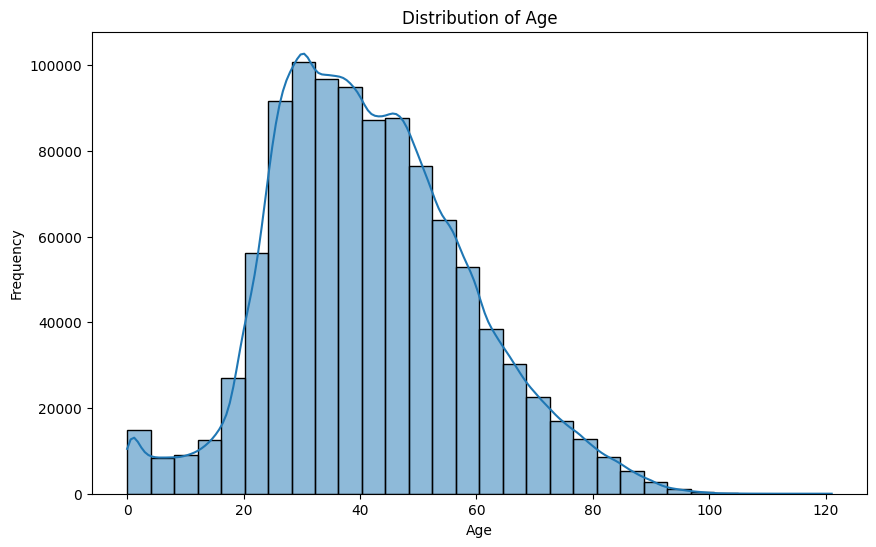

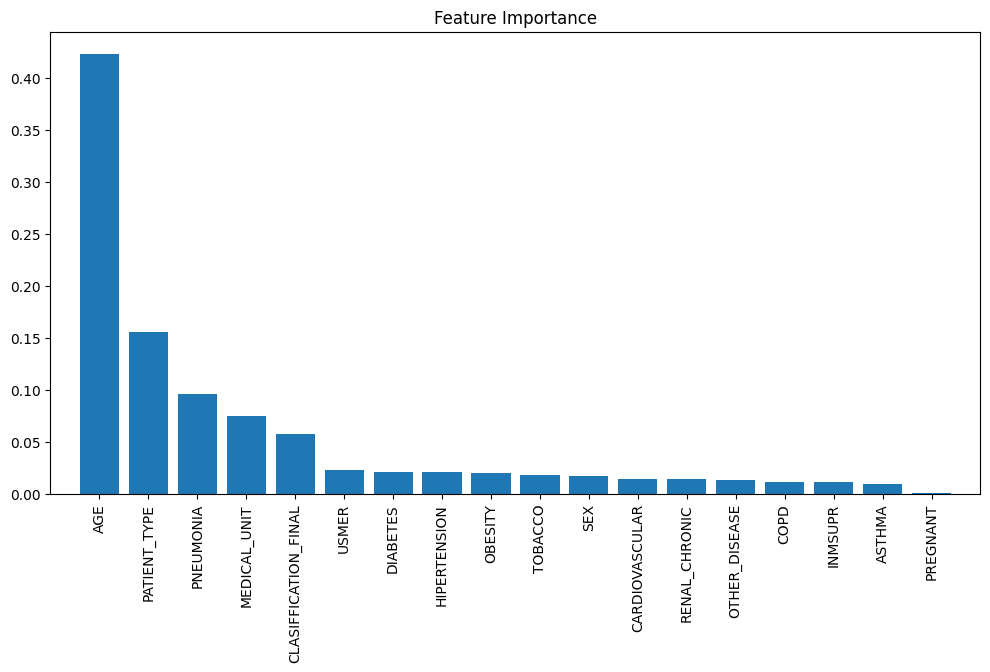

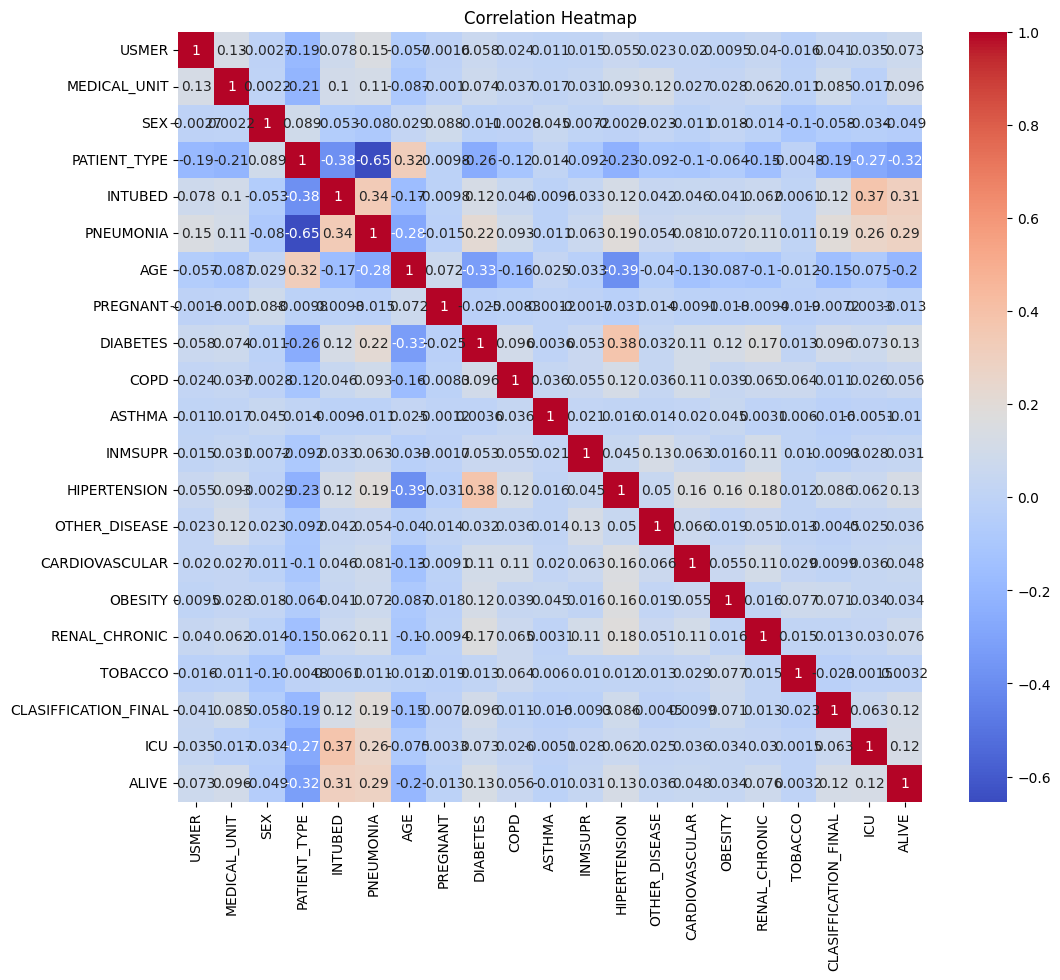

In [22]:
# Distribution of AGE
plt.figure(figsize=(10, 6))
sns.histplot(dropped_df['AGE'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Feature Importance
importances = model_intubed.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = dropped_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
